# Group 22 Project Final Report

*An Analysis of the Risk of Developing Heart Disease for Individuals in Cleveland, Ohio.*

## Introduction



Cardiovascular disease includes any condition that affects the circulatory system. This results in negative impacts on the function of the heart and veins, which differ from different types of cardiovascular disease (Thiriet, 1970). Cardiovascular disease is also commonly known as heart disease (Thiriet, 1970). In order to save many lives, it is essential that individuals with heart disease are diagnosed early to start treatment as soon as possible (Pal et al., 2022). A model that can accurately predict a heart disease diagnosis would have the potential to save countless lives (Pal et al., 2022). With an early diagnosis, treatment can begin earlier than what otherwise might have been possible, which decreases the chance of complications. 



Therefore the question we intend to answer is: Can we predict whether or not a patient in  Cleveland, Ohio is diagnosed with heart disease, given their variable x and y


The dataset we will be using was retrieved from "processed.cleveland.data" in the Heart Disease Data Set (https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) provided by UCI Machine Learning Repository. The dataset includes the following 14 attributes which can be numerical or categorical.

## Summary of Preliminary Analysis

We will start with a quick summary of our previous analysis. Our table describes which variables have apossible correlation with heart disease. We noticed some minor mistakes in our analysis but we will proceed with 2 numerical variables than seem to have correlation with heart disease

### Loading, Wrangling, and Cleaning the Data

In [1]:
import altair as alt
import numpy as np
np.random.seed(2023)
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

original_data = pd.read_csv(url, names=[
    "age", 
    "sex", 
    "chest_pain", 
    "resting_blood_pressure", 
    "cholesterol", 
    "fasting_blood_sugar", 
    "resting_electrocardiographic_results", 
    "max_heart_rate",
    "exercise_induced_angina",  
    "st_depression_exercise", 
    "slope_st", 
    "major_vessels", 
    "thal",
    "diagnosis"
])

hd_data = original_data.dropna(how='all')

# omit rows containing unclassified values
hd_data = hd_data.drop(
    hd_data[hd_data.major_vessels == '?'].index
)
hd_data["major_vessels"] = pd.to_numeric(hd_data["major_vessels"])

hd_data = hd_data.drop(
    hd_data[hd_data.thal == '?'].index
)

In [3]:
# replace numeric values with categorical lables for categorical variables 
# except for 'resting_electrocardiographic_results' which requires a long description for each label
hd_data["sex"] = hd_data["sex"].apply(lambda x: "male" if (x == 1.0) else "female")

hd_data["chest_pain"] = hd_data["chest_pain"].replace({
    1: 'Typical angina',
    2: 'Atypical angina',
    3: 'Non-anginal pain',
    4: 'Asymptomatic'
})

hd_data["fasting_blood_sugar"] = hd_data["fasting_blood_sugar"].apply(lambda x: True if (x == 1.0) else False)

hd_data["exercise_induced_angina"] = hd_data["exercise_induced_angina"].apply(lambda x: 'Yes' if (x == 1.0) else 'No')

hd_data["slope_st"] = hd_data["slope_st"].replace({
    1.0: 'Upsloping',
    2.0: 'Flat',
    3.0: 'Downsloping'
})

hd_data["thal"] = hd_data["thal"].replace({
    '3.0': 'Normal',
    '6.0': 'Fixed defect',
    '7.0': 'Reversable defect'
})


In [4]:
# define a column, 'heart_disease', based on the 'diagnosis' column and drop 'diagnosis'
hd_data["heart_disease"] = hd_data["diagnosis"].apply(
    lambda x: "undiagnosed" if (x == 0) else "diagnosed")
hd_data = hd_data.drop(columns=["diagnosis"])

hd_data.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,st_depression_exercise,slope_st,major_vessels,thal,heart_disease
0,63.0,male,Typical angina,145.0,233.0,True,2.0,150.0,No,2.3,Downsloping,0.0,Fixed defect,undiagnosed
1,67.0,male,Asymptomatic,160.0,286.0,False,2.0,108.0,Yes,1.5,Flat,3.0,Normal,diagnosed
2,67.0,male,Asymptomatic,120.0,229.0,False,2.0,129.0,Yes,2.6,Flat,2.0,Reversable defect,diagnosed
3,37.0,male,Non-anginal pain,130.0,250.0,False,0.0,187.0,No,3.5,Downsloping,0.0,Normal,undiagnosed
4,41.0,female,Atypical angina,130.0,204.0,False,2.0,172.0,No,1.4,Upsloping,0.0,Normal,undiagnosed


Now we have a 14-column dataset that contains six numerical variables and eight categorical variables. 

| # | Variable | Description | Value | Possible Correlation |
|---|----------|-------------|-------|----------------------|
| 1 | age | Individual's age | numerical | Yes; will check without the factor of sex |
| 2 | sex | Individual's sex | male or female | Yes |
| 3 | chest_pain | Chest pain type | Typical angina, Atypical angina, Non-anginal pain, or Asymptomatic | Yes |
| 4 | resting_blood_pressure | Resting blood pressure (in mm Hg on admission to the hospital) | numerical | worth checking a pattern |
| 5 | cholesterol | Serum cholestoral in mg/dL | numerical | re-analysis needed; will check distribution |
| 6 | fasting_blood_sugar | Fasting blood sugar > 120 mg/dL | True or False | No |
| 7 | resting_electrocardiographic_results | Resting electrocardiographic results | <ul><li>0: normal</li><li>1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)</li><li>2: showing probable or definite left ventricular hypertrophy by Estes' criteria</li></ul> | No |
| 8 | max_heart_rate | Maximum heart rate achieved | numerical | Yes; will check distribution |
| 9 | exercise_induced_angina | Exercise induced angina | Yes or No | Yes |
| 10 | st_depression_exercise | ST depression induced by exercise relative to rest | numerical | Yes; will check distribution |
| 11 | slope_st | The slope of the peak exercise ST segment | Upsloping, Flat, or Downsloping | Yes |
| 12 | major_vessels | Number of major vessels (0-3) colored by flourosopy | numerical | Yes |
| 13 | thal | Thalassemia | Normal, Fixed defect, or Reversable defect | Yes |
| 14 | heart_disease | Diagnosis of presence of heart disease | diagnosed or undiagnosed | NA |

### Training Data and Test Data

We will obtain a training data and a test data from the data that we have cleaned-up and use only *the training data*, `hd_train`, from now on. We will stratify the target column `heart_disease` to preserve the class proportion.

In [5]:
hd_train, hd_test = train_test_split(hd_data, test_size=0.25, stratify=hd_data["heart_disease"])
print(hd_train["heart_disease"].value_counts(normalize=True))
print(hd_test["heart_disease"].value_counts(normalize=True))

undiagnosed    0.540541
diagnosed      0.459459
Name: heart_disease, dtype: float64
undiagnosed    0.533333
diagnosed      0.466667
Name: heart_disease, dtype: float64


We will check some statistics for all six numeric variables in our training data, `hd_train`.

In [6]:
age_stat = hd_train.agg({'age': ['mean', 'median', 'min', 'max']}).round(decimals=1)
rbp_stat = hd_train.agg({'resting_blood_pressure': ['mean', 'median', 'min', 'max']}).round(decimals=2)
chol_stat = hd_train.agg({'cholesterol': ['mean', 'median', 'min', 'max']}).round(decimals=2)
max_hr_stat = hd_train.agg({'max_heart_rate': ['mean', 'median', 'min', 'max']}).round(decimals=2)
st_depression_exercise = hd_train.agg({'st_depression_exercise': ['mean', 'median', 'min', 'max']}).round(decimals=2)
major_vessels = hd_train.agg({'major_vessels': ['mean', 'median', 'min', 'max']}).round(decimals=2)

num_stat = pd.concat([age_stat, rbp_stat, chol_stat, max_hr_stat, st_depression_exercise, major_vessels], axis=1)
num_stat.transpose()

,mean,median,min,max
age,54.20,55.0,34.0,77.0
resting_blood_pressure,130.86,130.0,94.0,192.0
cholesterol,245.27,240.0,131.0,564.0
max_heart_rate,149.65,153.5,88.0,195.0
st_depression_exercise,1.06,0.8,0.0,5.6
major_vessels,0.64,0.0,0.0,3.0


We see some variations of scales in the above variables, so we will need to scale them for the later data analysis. However, we won't do so in our exploratory analysis because we will just compare the diagnosis variable, which is categorical, and one other variable.

### Exploratory Data Analysis

Now, we will make some plots to see if there is a possible correlational relationship between a variable and the diagnosis. Note: the count of individuals in the following plots will only refer to the observations in the training data.

In [7]:
# define a custom theme to make plots readable (you can overwrite these settings by local config)
def readable_labels():
    return {
        'config': {
            'view': {'height': 300, 'width': 300},
            'title': {'fontSize': 18},
            "axisX": {"labelFontSize": 15, "titleFontSize": 15},
            "axisY": {"labelFontSize": 15, "titleFontSize": 15},
            "legend": {"labelFontSize": 15, "titleFontSize": 15},
        }
    }
alt.themes.register('readable_labels', readable_labels)
alt.themes.enable('readable_labels')

ThemeRegistry.enable('readable_labels')

In [8]:
age_hist = (alt.Chart()
            .mark_bar()
            .encode(
                x=alt.X("age", title="Age", bin=alt.Bin(maxbins=30)),
                y=alt.Y("count()", title="Count of individuals", stack=False),
            )
            .properties(height=150, width=400)
           )
age_hist_facet = (age_hist
                  .facet(
                      facet=alt.Facet("heart_disease", title="Heart disease", header=alt.Header(labelFontSize=15, titleFontSize=15)),
                      data=hd_train,
                      columns=1,
                      title='Age vs Heart Disease'
                  )
                 )
age_hist_facet

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

We can see the individuals who were diagnosed to heart disease appear within the range of 50s to 60s. On the other hand, we can see that individuals who were not diagnosed spread over the broad range from 30s to 70s.

In [9]:
sex_bar_graph = (alt.Chart(hd_train, title = "The Differentiation in the Number of Individuals with Heart Disease by Sex")
                 .mark_bar()
                 .encode(
                     # x=alt.X("count()", title= "Count of individuals"), 
                     x=alt.X("count()", title= "Count of individuals", stack="normalize", axis=alt.Axis(format='%')),
                     y=alt.Y("sex"),
                     color="heart_disease"
                 ).properties(width=380, height=150)
)
sex_bar_graph

alt.Chart(...)

Since we have fewer observations of females in our dataset, we compared the ratio of dianosis. By looking at the proportion of diagnosed individuals, we can see males show a larger proportion of being diagnosed for heart hisease than females.

In [10]:
chest_pain_graph = (
    alt.Chart(hd_train, title = "Chest Pain vs Heart Disease")
    .mark_bar()
    .encode(
        x=alt.X("count()", title="Count of individuals"), 
        y=alt.Y("chest_pain:N", title="Type of chest pain"),
        color="heart_disease"
    ).properties(width=380, height=200)
)
chest_pain_graph

alt.Chart(...)

Here we see that for the asymptomatic type of chest pain, the majority of people have been disagnosed with heart disease. Non-anginal pain is the second most recorded chest pain type, but the large portion of it is subjected to undiagnosed for heart disease.

When compared to the other types of chest pain, the data may indicate a slight correlation between an asymptomatic type of pain and heart disease; although, chest pain alone might not be a good indicator of heart disease.

In [11]:
resting_blood_pressure_graph = (
    alt.Chart(hd_train, title = "Resting Blood Pressure vs Heart Disease")  
    .mark_point()
    .encode(
        x=alt.X("resting_blood_pressure", title= "Resting Blood Pressure (mm Hg)", scale=alt.Scale(zero=False)), 
        y=alt.Y("count()", title= "Count of Individuals"),
        color="heart_disease"
    )
)
resting_blood_pressure_graph

alt.Chart(...)

There seems to be a weak pattern between resting blood pressure and the dianosis to heart disease;  individuals diagnosed to heart disease tend to appear in the right side of the plot, which area represents higher blood pressure.

In [12]:
cholesterol_hist = (alt.Chart()
            .mark_bar()
            .encode(
                x=alt.X("cholesterol", title="Serum cholesterol (mg/dL)", bin=alt.Bin(maxbins=30)),
                y=alt.Y("count()", title="Count of individuals"),
            )
            .properties(height=200, width=400)
           )
cholesterol_hist_facet = (cholesterol_hist
                  .facet(
                      facet=alt.Facet("heart_disease", title="Dianosis to Heart Disease", header=alt.Header(labelFontSize=15, titleFontSize=15)),
                      data=hd_train,
                      columns=1,
                      title="Cholesterol vs Heart Disease"
                  )
                 )
cholesterol_hist_facet

alt.FacetChart(...)

The distribution of the values of serum cholesterol (mg/dL) for diagnosed indivduals and that for undiagnosed individuals are very similar. It seems to be no pattern between heart disease and cholesterol.

In [13]:
# replace the values of fasting_blood_sugar with labels
hd_train["fasting_blood_sugar"] = hd_train["fasting_blood_sugar"].replace({
    True: '> 120 mg/dL',
    False: '<= 120 mg/dL'
})

fasting_blood_sugar_graph = (
    alt.Chart(hd_train, title = "Fasting blood sugar vs Heart Disease")  
    .mark_bar()
    .encode(
        x=alt.X("count()", title= "Count of Individuals"), color="heart_disease",
        y=alt.Y("fasting_blood_sugar", title= "Fasting blood sugar"), 
    ).properties(width=400, height=200)
)
fasting_blood_sugar_graph 

alt.Chart(...)

The proportions of diagnosed and undiagnosed indivisuals seem similar in both categories, so we will regard this as little to no correlation for now.

In [14]:
# replace the values of resting_electrocardiographic_results
hd_train["resting_electrocardiographic_results"] = hd_train[
    "resting_electrocardiographic_results"].replace({
    0: 'Normal',
    1: 'ST-T abnormality',
    2: 'Probable or definite left ventricular hypertrophy',
})

restecg_graph = (
    alt.Chart(hd_train, title = "Resting electrocardiographic results vs Heart Disease")  
    .mark_bar()
    .encode(
        x=alt.X("count()", title= "Count of Individuals"), color="heart_disease",
        y=alt.Y("resting_electrocardiographic_results:N", title=["Resting electrocardiographic", "results"]), 
    ).properties(width=400, height=150)
)
restecg_graph

alt.Chart(...)

There seems to be more individuals with the result of **probable or definite left ventricular hypertrophy by Estes' criteria** that are diagnosed with heart disease than for a result of **having ST-T wave abnormality**. We will consider this a small correlation for now. 

In [15]:
max_heart_rate_hist = (
    alt.Chart()
    .mark_bar()
    .encode(
        x=alt.X("max_heart_rate", title="Maximum heart rate achieved", bin=alt.Bin(maxbins=30)),
        y=alt.Y("count()", title="Count of individuals"),
    )
    .properties(height=150, width=400)
)
max_heart_rate_hist_facet = (
    max_heart_rate_hist
    .facet(
        facet=alt.Facet("heart_disease", title="Dianosis to Heart Disease", header=alt.Header(labelFontSize=15, titleFontSize=15)),
        data=hd_train,
        columns=1,
        title="Maximum Heart Rate Achieved vs Heart Disease"
    )
)
max_heart_rate_hist_facet

alt.FacetChart(...)

We can definitely see the distribution of maximu heart rate for undiagnosed individuals is right-skewed. We are not quite sure what this means but will keep this possible correlation in mind for future reference and decision on variables.

In [16]:
exercise_induced_angina_graph = (
    alt.Chart(hd_train, title = "Exercise Induced Angina vs Heart Disease")  
    .mark_bar()
    .encode(
        x=alt.X("count()", title= "Count of Individuals"),
        y=alt.Y("exercise_induced_angina", title=["Experience of", "exercise induced angina"]), 
        color="heart_disease"
    ).properties(width=300, height=150)
)
exercise_induced_angina_graph

alt.Chart(...)

The proportion of diagnosed individuals who experienced the exercise induced angina is higher than the proportion of undiagnosed people, which leads us to say there may be a correlation between this variable and heart disease.

In [17]:
st_depression_exercise_hist = (alt.Chart()
            .mark_bar()
            .encode(
                x=alt.X("st_depression_exercise", title="ST depression induced by exercise relative to rest", bin=alt.Bin(maxbins=30)),
                y=alt.Y("count()", title="Count of individuals"),
            )
            .properties(height=150, width=400)
           )
st_depression_exercise_hist_facet = (st_depression_exercise_hist
                  .facet(
                      facet=alt.Facet("heart_disease", title="Dianosis to Heart Disease", header=alt.Header(labelFontSize=15, titleFontSize=15)),
                      data=hd_train,
                      columns=1,
                      title="ST Depression Induced by Exercise vs Heart Disease"
                  )
                 )
st_depression_exercise_hist_facet

alt.FacetChart(...)

There seems to be a coreelation between heart disease diagnosis and ST depression induced by exercise relative to rest. Undiagnosed individuals are seen around 0 to 2.0, whereas diagnosed individuals are seen within a broader range at the higher ST depression rates.

In [18]:
slope_st_graph = (
    alt.Chart(hd_train, title=["The Slope of the Peak Exercise", "ST Segment vs Heart Disease"])  
    .mark_bar()
    .encode(
        x=alt.X("count()", title="Count of individuals"), color="heart_disease",
        y=alt.Y("slope_st", title=["Slope of the peak", "exercise ST segment"]),
    ).properties(width=400, height=150)
)
slope_st_graph

alt.Chart(...)

The proportion of individuals diagnosed with heart disease is highest for the flat/no slope. However, as we do not have much domain knowledge about reading the ST segment and have not deeply understood this variable from our searches, we will leave this variable out of our analysis.

In [19]:
major_vessels_graph = (
    alt.Chart(hd_train, title = "Number of Major Vessels vs Heart Disease")  
    .mark_bar()
    .encode(
        x=alt.X("major_vessels:N", title= "Number of major vessels (0-3) colored by fluoroscopy"), 
        y=alt.Y("count()", title= "Count of Individuals"), color="heart_disease"
    )
)
major_vessels_graph

alt.Chart(...)

The more major vessels are colored the higher the percentage of diagnosed individuals becomes, We think this could be an important variable for our question.

In [20]:
thalassemia_graph = (
    alt.Chart(hd_train, title = "Thalassemia vs Heart Disease")  
    .mark_bar()
    .encode(
        x=alt.X("count()", title= "Count of Individuals"), color="heart_disease",
        y=alt.Y("thal", title= "Presence of Thalassemia")
    ).properties(width=400, height=150)
)

thalassemia_graph

alt.Chart(...)

We can clearly see that there is a strong correlation between a diagnosis of heart disease and thalassemia from the large porition of diagnosed individuals in the category of "Reversable defect."

## Data Analysis with Selected Variables

We will do classification with two numeric variables. We will try out multiple sets of variables to seek a combination gives us a better result.

#### Set 1: Resting Blood Pressure and Cholesterol

We will show a pattern in the two varibles, `resting_blood_pressure` and `cholesterol`, by using the K nearest neighbors classification.

In [21]:
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# try to see the result with n=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
X_train_restbp_chol = hd_train.loc[:, ["resting_blood_pressure", "cholesterol"]]
y = hd_train["heart_disease"]

hd_preprocessor_restbp_chol = make_column_transformer(
    (StandardScaler(), ["resting_blood_pressure", "cholesterol"]),
)
pipe_restbp_chol_k5 = make_pipeline(hd_preprocessor_restbp_chol, knn_5)
knn_fit_restbp_chol = pipe_restbp_chol_k5.fit(X_train_restbp_chol, y)

cv_5_df_1 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_chol_k5, cv=5, X=X_train_restbp_chol, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_1["test_score"].mean())

cv_10_df_1 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_chol_k5, cv=10, X=X_train_restbp_chol, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_1["test_score"].mean())

Mean test score (5-fold cross-validation):  0.5005050505050506
Mean test score (10-fold cross-validation):  0.5001976284584979


So, the test score with K=5 is around 50% . Now we will look for the best K to improve our prediction by using Grid Search

In [23]:
knn = KNeighborsClassifier()
tune_pipe_restbp_chol = make_pipeline(hd_preprocessor_restbp_chol, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_restbp_chol = GridSearchCV(
    estimator=tune_pipe_restbp_chol,
    param_grid=param_grid,
    cv=5
)
tune_grid_restbp_chol

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['resting_blood_pressure',
                                                                          'cholesterol'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [24]:
accuracies_grid_restbp_chol = pd.DataFrame(
    tune_grid_restbp_chol.fit(X_train_restbp_chol, y).cv_results_
)

accuracies_restbp_chol = accuracies_grid_restbp_chol[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_restbp_chol["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_restbp_chol = (
    alt.Chart(accuracies_restbp_chol)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_restbp_chol

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K=9 shows the highest test scores with pretty low values of the standard error. So, we will pick up K=9 to build our model. We will check the accuracy with the ratio of correct prediction and accuracy score. We will also check the confusion matrix.

In [25]:
# try to see the result with n=9
knn_9 = KNeighborsClassifier(n_neighbors=9)
knn_fit_restbp_chol_9 = make_pipeline(hd_preprocessor_restbp_chol, knn_9).fit(X_train_restbp_chol, y)

pred_restbp_chol_9 = hd_train.assign(
    predicted = knn_fit_restbp_chol_9.predict(hd_train.loc[:, ["resting_blood_pressure", "cholesterol"]])
)

# check the accuracy of the prediction by the ratio
correct_preds_restbp_chol_9 = pred_restbp_chol_9[
    pred_restbp_chol_9["heart_disease"] == pred_restbp_chol_9["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_restbp_chol_9.shape[0] / pred_restbp_chol_9.shape[0])

# check the score of accuracy
pred_accuracy_restbp_chol_9 = knn_fit_restbp_chol_9.score(
    X = X_train_restbp_chol,
    y = y
)
print("Accuracy: ", pred_accuracy_restbp_chol_9)

Ratio of correct prediction:  0.6126126126126126
Accuracy:  0.6126126126126126


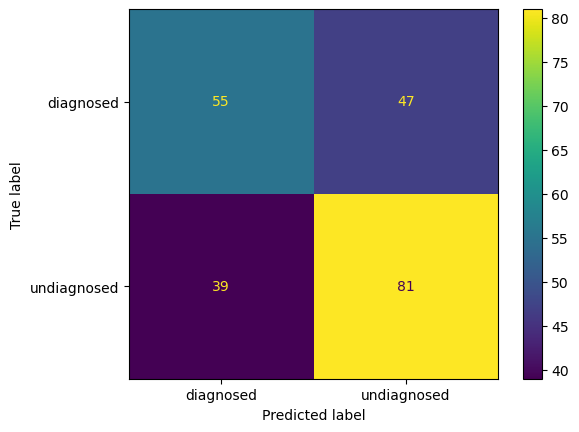

In [26]:
restbp_chol_9_mat = confusion_matrix(
    pred_restbp_chol_9["heart_disease"],  # true labels
    pred_restbp_chol_9["predicted"],  # predicted labels
    labels=knn_fit_restbp_chol_9.classes_, # specify the label for each class
)
disp_restbp_chol_9 = ConfusionMatrixDisplay(
    confusion_matrix=restbp_chol_9_mat, display_labels=knn_fit_restbp_chol_9.classes_
)
disp_restbp_chol_9.plot()

### Set 2: Resting Blood Pressure and Max Heart Rate

We will show a pattern in the two varibles, resting_blood_pressure and max_heart_rate, by using the K nearest neighbors classification.

In [27]:
# try to see the result with n=5
X_train_restbp_maxhr = hd_train.loc[:, ["resting_blood_pressure", "max_heart_rate"]]
y = hd_train["heart_disease"]

hd_preprocessor_restbp_maxhr = make_column_transformer(
    (StandardScaler(), ["resting_blood_pressure", "max_heart_rate"]),
)
pipe_restbp_maxhr_k5 = make_pipeline(hd_preprocessor_restbp_maxhr, knn_5)
knn_fit_restbp_maxhr = pipe_restbp_maxhr_k5.fit(X_train_restbp_maxhr, y)

cv_5_df_2 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_maxhr_k5, cv=5, X=X_train_restbp_maxhr, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_2["test_score"].mean())

cv_10_df_2 = pd.DataFrame(
    cross_validate(estimator = pipe_restbp_maxhr_k5, cv=10, X=X_train_restbp_maxhr, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_2["test_score"].mean())

Mean test score (5-fold cross-validation):  0.6128282828282828
Mean test score (10-fold cross-validation):  0.6219367588932806


So, the test score with K=5 may be around 62%. Now we will look for the best K to improve our prediction by using Grid Search.

In [28]:
knn = KNeighborsClassifier()
tune_pipe_restbp_maxhr = make_pipeline(hd_preprocessor_restbp_maxhr, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_restbp_maxhr = GridSearchCV(
    estimator=tune_pipe_restbp_maxhr,
    param_grid=param_grid,
    cv=5
)
tune_grid_restbp_maxhr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['resting_blood_pressure',
                                                                          'max_heart_rate'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [29]:
accuracies_grid_restbp_maxhr = pd.DataFrame(
    tune_grid_restbp_maxhr.fit(X_train_restbp_maxhr, y).cv_results_
)

accuracies_restbp_maxhr = accuracies_grid_restbp_maxhr[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_restbp_maxhr["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_restbp_maxhr = (
    alt.Chart(accuracies_restbp_maxhr)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_restbp_maxhr

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>16 shows higher test scores than K<17 with lower values of the standard error. So, we will pick up K=17 here. We will check the accuracy with the ratio of correct prediction and accuracy score. We will also check the confusion matrix.

In [30]:
# try to see the result with n=17
knn_17 = KNeighborsClassifier(n_neighbors=17)
knn_fit_restbp_maxhr_17 = make_pipeline(hd_preprocessor_restbp_maxhr, knn_17).fit(X_train_restbp_maxhr, y)

pred_restbp_maxhr_17 = hd_train.assign(
    predicted = knn_fit_restbp_maxhr_17.predict(hd_train.loc[:, ["resting_blood_pressure", "max_heart_rate"]])
)

# check the accuracy of the prediction by the ratio
correct_preds_restbp_maxhr_17 = pred_restbp_maxhr_17[
    pred_restbp_maxhr_17["heart_disease"] == pred_restbp_maxhr_17["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_restbp_maxhr_17.shape[0] / pred_restbp_maxhr_17.shape[0])

# check the score of accuracy
pred_accuracy_restbp_maxhr_17 = knn_fit_restbp_maxhr_17.score(
    X = X_train_restbp_maxhr,
    y = y
)
print("Accuracy: ", pred_accuracy_restbp_maxhr_17)

Ratio of correct prediction:  0.7072072072072072
Accuracy:  0.7072072072072072


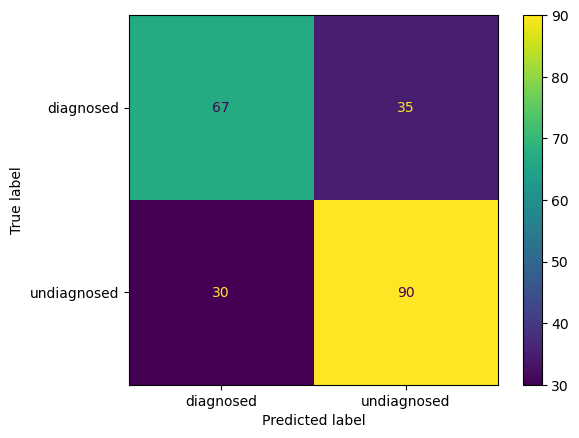

In [31]:
restbp_maxhr_17_mat = confusion_matrix(
    pred_restbp_maxhr_17["heart_disease"],  # true labels
    pred_restbp_maxhr_17["predicted"],  # predicted labels
    labels=knn_fit_restbp_maxhr_17.classes_, # specify the label for each class
)
disp_restbp_maxhr_17 = ConfusionMatrixDisplay(
    confusion_matrix=restbp_maxhr_17_mat, display_labels=knn_fit_restbp_maxhr_17.classes_
)
disp_restbp_maxhr_17.plot()

### Set 3: Cholesterol and Maximum Heart Rate Achieved

We will show a pattern in the two varibles, cholesterol and max_heart_rate, by using the K nearest neighbors classification. First, we will perform 5-fold and 10-fold cross-validation with K=5 to see the mean value of the test scores.

In [32]:
# try to see the result with n=5
X_train_chol_maxhr = hd_train.loc[:, ["cholesterol", "max_heart_rate"]]
y = hd_train["heart_disease"]

hd_preprocessor_chol_maxhr = make_column_transformer(
    (StandardScaler(), ["cholesterol", "max_heart_rate"]),
)
pipe_chol_maxhr_k5 = make_pipeline(hd_preprocessor_chol_maxhr, knn_5)
knn_fit_chol_maxhr = pipe_chol_maxhr_k5.fit(X_train_chol_maxhr, y)

cv_5_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_chol_maxhr_k5, cv=5, X=X_train_chol_maxhr, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_3["test_score"].mean())

cv_10_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_chol_maxhr_k5, cv=10, X=X_train_chol_maxhr, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_3["test_score"].mean())

Mean test score (5-fold cross-validation):  0.6393939393939394
Mean test score (10-fold cross-validation):  0.6480237154150197


So, the test score with K=5 may be around 64%. Now we will look for the best K to improve our prediction. Now we will look for a best K to improve our prediction.

In [33]:
knn = KNeighborsClassifier()
tune_pipe_chol_maxhr = make_pipeline(hd_preprocessor_chol_maxhr, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_chol_maxhr = GridSearchCV(
    estimator=tune_pipe_chol_maxhr,
    param_grid=param_grid,
    cv=5
)
tune_grid_chol_maxhr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cholesterol',
                                                                          'max_heart_rate'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [34]:
accuracies_grid_chol_maxhr = pd.DataFrame(
    tune_grid_chol_maxhr
    .fit(X_train_chol_maxhr, y).cv_results_
)

accuracies_chol_maxhr = accuracies_grid_chol_maxhr[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_chol_maxhr["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_chol_maxhr = (
    alt.Chart(accuracies_chol_maxhr)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_chol_maxhr

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>15 shows higher test scores than K<16 with lower values of the standard error. So, we will pick up K=20 here. We will check the accuracy with the ratio of correct prediction and accuracy score. We will also check the confusion matrix.

In [35]:
# try to see the result with n=20
knn_20 = KNeighborsClassifier(n_neighbors=20)
knn_fit_chol_maxhr_20 = make_pipeline(hd_preprocessor_chol_maxhr, knn_20).fit(X_train_chol_maxhr, y)

pred_chol_maxhr_20 = hd_train.assign(
    predicted = knn_fit_chol_maxhr_20.predict(X_train_chol_maxhr)
)

# check the accuracy of the prediction by the ratio
correct_preds_chol_maxhr_20 = pred_chol_maxhr_20[
    pred_chol_maxhr_20["heart_disease"] == pred_chol_maxhr_20["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_chol_maxhr_20.shape[0] / pred_chol_maxhr_20.shape[0])

# check the score of accuracy
pred_accuracy_chol_maxhr_20 = knn_fit_chol_maxhr_20.score(
    X = X_train_chol_maxhr,
    y = y
)
print("Accuracy: ", pred_accuracy_chol_maxhr_20)

Ratio of correct prediction:  0.7072072072072072
Accuracy:  0.7072072072072072


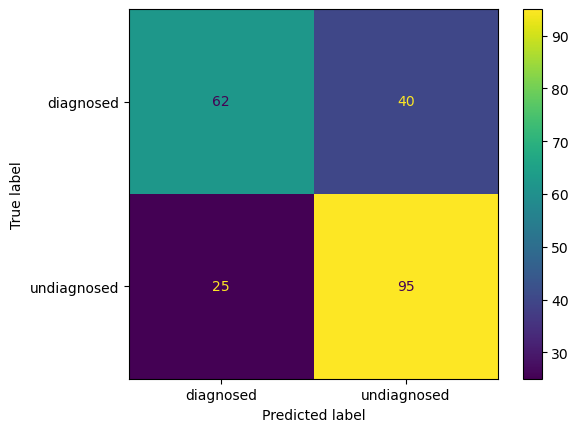

In [36]:
chol_maxhr_20_mat = confusion_matrix(
    pred_chol_maxhr_20["heart_disease"],  # true labels
    pred_chol_maxhr_20["predicted"],  # predicted labels
    labels=knn_fit_chol_maxhr_20.classes_, # specify the label for each class
)
disp_chol_maxhr_20 = ConfusionMatrixDisplay(
    confusion_matrix=chol_maxhr_20_mat, display_labels=knn_fit_chol_maxhr_20.classes_
)
disp_chol_maxhr_20.plot()

### Set 4: Maximum Heart Rate Achieved and ST depression

We will show a pattern in the two varibles, max_heart_rate and st_depression_exercise (ST depression induced by exercise relative to rest,) by using the K nearest neighbors classification.

In [37]:
# try to see the result with n=5
X_train_maxhr_stde = hd_train.loc[:, ["max_heart_rate", "st_depression_exercise"]]
y = hd_train["heart_disease"]

hd_preprocessor_maxhr_stde = make_column_transformer(
    (StandardScaler(), ["max_heart_rate", "st_depression_exercise"]),
)
pipe_maxhr_stde_k5 = make_pipeline(hd_preprocessor_maxhr_stde, knn_5)
knn_fit_maxhr_stde = pipe_maxhr_stde_k5.fit(X_train_maxhr_stde, y)

cv_5_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_maxhr_stde_k5, cv=5, X=X_train_maxhr_stde, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_3["test_score"].mean())

cv_10_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_maxhr_stde_k5, cv=10, X=X_train_maxhr_stde, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_3["test_score"].mean())

Mean test score (5-fold cross-validation):  0.6713131313131313
Mean test score (10-fold cross-validation):  0.6758893280632411


So, the test score with K=5 may be around 67%. Now we will look for the best K to improve our prediction. Now we will look for a best K to improve our prediction.

In [38]:
knn = KNeighborsClassifier()
tune_pipe_maxhr_stde = make_pipeline(hd_preprocessor_maxhr_stde, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_maxhr_stde = GridSearchCV(
    estimator=tune_pipe_maxhr_stde,
    param_grid=param_grid,
    cv=5
)
tune_grid_maxhr_stde

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['max_heart_rate',
                                                                          'st_depression_exercise'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [39]:
accuracies_grid_maxhr_stde = pd.DataFrame(
    tune_grid_maxhr_stde
    .fit(X_train_maxhr_stde, y).cv_results_
)

accuracies_maxhr_stde = accuracies_grid_maxhr_stde[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_maxhr_stde["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_maxhr_stde = (
    alt.Chart(accuracies_maxhr_stde)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_maxhr_stde

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>10 shows higher test scores than K<11 with lower values of the standard error. So, we will pick up K=11 here. We will check the accuracy with the ratio of correct prediction and accuracy score. We will also check the confusion matrix.

In [40]:
# try to see the result with n=11
knn_11 = KNeighborsClassifier(n_neighbors=11)
knn_fit_maxhr_stde_11 = make_pipeline(hd_preprocessor_maxhr_stde, knn_11).fit(X_train_maxhr_stde, y)

pred_maxhr_stde_11 = hd_train.assign(
    predicted = knn_fit_maxhr_stde_11.predict(X_train_maxhr_stde)
)

# check the accuracy of the prediction by the ratio
correct_preds_maxhr_stde_11 = pred_maxhr_stde_11[
    pred_maxhr_stde_11["heart_disease"] == pred_maxhr_stde_11["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_maxhr_stde_11.shape[0] / pred_maxhr_stde_11.shape[0])

# check the score of accuracy
pred_accuracy_maxhr_stde_11 = knn_fit_maxhr_stde_11.score(
    X = X_train_maxhr_stde,
    y = y
)
print("Accuracy: ", pred_accuracy_maxhr_stde_11)

Ratio of correct prediction:  0.7297297297297297
Accuracy:  0.7297297297297297


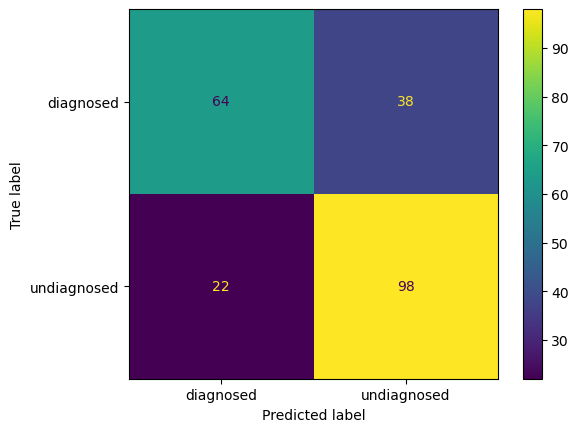

In [41]:
maxhr_stde_11_mat = confusion_matrix(
    pred_maxhr_stde_11["heart_disease"],  # true labels
    pred_maxhr_stde_11["predicted"],  # predicted labels
    labels=knn_fit_maxhr_stde_11.classes_, # specify the label for each class
)
disp_maxhr_stde_11 = ConfusionMatrixDisplay(
    confusion_matrix=maxhr_stde_11_mat, display_labels=knn_fit_maxhr_stde_11.classes_
)
disp_maxhr_stde_11.plot()

### Set 5: Maximum Heart Rate Achieved and Number of Major Vessels Colored by Flourosopy

We will show a pattern in the two varibles, max_heart_rate and major_vessels, by using the K nearest neighbors classification.

In [42]:
# try to see the result with n=5
X_train_maxhr_majorv = hd_train.loc[:, ["max_heart_rate", "major_vessels"]]
y = hd_train["heart_disease"]

hd_preprocessor_maxhr_majorv = make_column_transformer(
    (StandardScaler(), ["max_heart_rate", "major_vessels"]),
)
pipe_maxhr_majorv_k5 = make_pipeline(hd_preprocessor_maxhr_majorv, knn_5)
knn_fit_maxhr_majorv = pipe_maxhr_majorv_k5.fit(X_train_maxhr_majorv, y)

cv_5_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_maxhr_majorv_k5, cv=5, X=X_train_maxhr_majorv, y=y, return_train_score=True)
)
print("Mean test score (5-fold cross-validation): ", cv_5_df_3["test_score"].mean())

cv_10_df_3 = pd.DataFrame(
    cross_validate(estimator = pipe_maxhr_majorv_k5, cv=10, X=X_train_maxhr_majorv, y=y, return_train_score=True)
)
print("Mean test score (10-fold cross-validation): ", cv_10_df_3["test_score"].mean())

Mean test score (5-fold cross-validation):  0.7301010101010101
Mean test score (10-fold cross-validation):  0.7519762845849802


So, the test score with K=5 may be around 74%. Now we will look for the best K to improve our prediction. Now we will look for a best K to improve our prediction.

In [43]:
knn = KNeighborsClassifier()
tune_pipe_maxhr_majorv = make_pipeline(hd_preprocessor_maxhr_majorv, knn)
param_grid = {"kneighborsclassifier__n_neighbors": range(1, 30)}

tune_grid_maxhr_majorv = GridSearchCV(
    estimator=tune_pipe_maxhr_majorv,
    param_grid=param_grid,
    cv=5
)
tune_grid_maxhr_majorv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['max_heart_rate',
                                                                          'major_vessels'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 30)})

We will check the cross-validation accuracy estimate and the standard error for the K values from 1 to 29.

In [44]:
accuracies_grid_maxhr_majorv = pd.DataFrame(
    tune_grid_maxhr_majorv
    .fit(X_train_maxhr_majorv, y).cv_results_
)

accuracies_maxhr_majorv = accuracies_grid_maxhr_majorv[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid_maxhr_majorv["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracy_k_grid_maxhr_majorv = (
    alt.Chart(accuracies_maxhr_majorv)
    .mark_line(point=True)
    .encode(
      alt.X(alt.repeat("column"), type='quantitative'),
      alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    )
    .properties(width=300, height=300)
    .repeat(
      row=['mean_test_score', 'sem_test_score'],
      column=['n_neighbors']
    )
)
accuracy_k_grid_maxhr_majorv

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

We can see K>9 shows higher test scores than K<10 with lower values of the standard error. So, we will pick up K=10 here. We will check the accuracy with the ratio of correct prediction and accuracy score. We will also check the confusion matrix.

In [45]:
# try to see the result with n=10
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_fit_maxhr_majorv_10 = make_pipeline(hd_preprocessor_maxhr_majorv, knn_10).fit(X_train_maxhr_majorv, y)

pred_maxhr_majorv_10 = hd_train.assign(
    predicted = knn_fit_maxhr_majorv_10.predict(X_train_maxhr_majorv)
)

# check the accuracy of the prediction by the ratio
correct_preds_maxhr_majorv_10 = pred_maxhr_majorv_10[
    pred_maxhr_majorv_10["heart_disease"] == pred_maxhr_majorv_10["predicted"]
]
print("Ratio of correct prediction: ", correct_preds_maxhr_majorv_10.shape[0] / pred_maxhr_majorv_10.shape[0])

# check the score of accuracy
pred_accuracy_maxhr_majorv_10 = knn_fit_maxhr_majorv_10.score(
    X = X_train_maxhr_majorv,
    y = y
)
print("Accuracy: ", pred_accuracy_maxhr_majorv_10)

Ratio of correct prediction:  0.7837837837837838
Accuracy:  0.7837837837837838


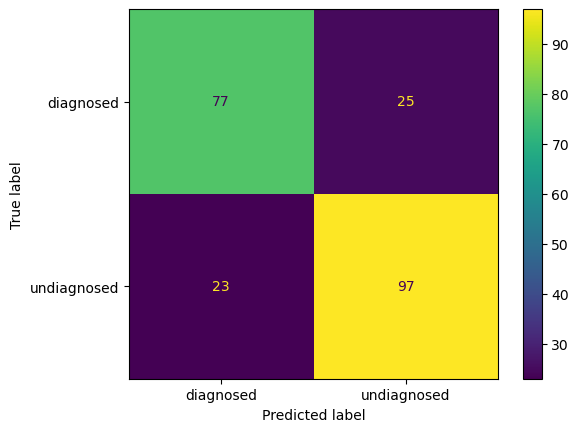

In [46]:
maxhr_majorv_10_mat = confusion_matrix(
    pred_maxhr_majorv_10["heart_disease"],  # true labels
    pred_maxhr_majorv_10["predicted"],  # predicted labels
    labels=knn_fit_maxhr_majorv_10.classes_, # specify the label for each class
)
disp_maxhr_majorv_10 = ConfusionMatrixDisplay(
    confusion_matrix=maxhr_majorv_10_mat, display_labels=knn_fit_maxhr_majorv_10.classes_
)
disp_maxhr_majorv_10.plot()

### References

- Index of /ml/machine-learning-databases/heart-disease. (n.d.). Retrieved April 8, 2023, from       https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ 

- Namara, K. M., Alzubaidi, H., & Jackson, J. K. (2019, February 4). Cardiovascular disease as a leading cause of death: How are pharmacist: IPRP. Integrated Pharmacy Research and Practice. Retrieved March 9, 2023, from https://www.dovepress.com/cardiovascular-disease-as-a-leading-cause-of-death-how-are-pharmacists-peer-reviewed-fulltext-article-IPRP

- Pal, M., Parija, S., Panda, G., Dhama, K., & Mohapatra, R. K. (2022, January 1). Risk prediction of cardiovascular disease using Machine Learning Classifiers. De Gruyter. Retrieved March 9, 2023, from https://www.degruyter.com/document/doi/10.1515/med-2022-0508/html

- Thiriet, M. (1970, January 1). Cardiovascular disease: An introduction. SpringerLink. Retrieved March 9, 2023, from https://link.springer.com/chapter/10.1007/978-3-319-89315-0_1 

